# Homework 4: Text Generation Quality Evaluation

## Track A: Question Answering (QA)

### Track Justification
Track A (Question Answering) was chosen because:
1. QA is a fundamental task that tests model comprehension and factual accuracy
2. SberQuAD provides high-quality Russian language QA pairs with context
3. Clear metrics (F1, Exact Match) allow objective comparison between models

### Models Compared (via Ollama - FREE, local)
- **qwen2.5:1.5b** - Alibaba's efficient small model (1.5B params)
- **gemma2:2b** - Google's compact model (2B params)

### Dataset
- **SberQuAD** - Russian version of SQuAD dataset from Hugging Face (kuznetsoffandrey/sberquad)
- Using 50 samples for evaluation

## Prerequisites: Install Ollama

1. Download Ollama from https://ollama.ai
2. Install and run Ollama
3. Pull the models:
```bash
ollama pull qwen2.5:1.5b
ollama pull gemma2:2b
```

## Part 1: Setup and Data Preparation

In [15]:
# Install required packages
!pip install datasets sacrebleu sentence-transformers requests nltk scikit-learn matplotlib seaborn pandas numpy -q

In [16]:
import os
import time
import json
import re
import requests
from collections import Counter
from typing import List, Dict, Tuple, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import sacrebleu
import nltk

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [17]:
# Ollama API configuration
OLLAMA_BASE_URL = "http://localhost:11434"

def check_ollama_connection():
    """Check if Ollama is running."""
    try:
        response = requests.get(f"{OLLAMA_BASE_URL}/api/tags", timeout=5)
        if response.status_code == 200:
            models = response.json().get('models', [])
            print("Ollama is running!")
            print(f"Available models: {[m['name'] for m in models]}")
            return True
    except requests.exceptions.ConnectionError:
        print("ERROR: Ollama is not running!")
        print("Please start Ollama and run: ollama pull qwen2.5:1.5b && ollama pull gemma2:2b")
        return False
    return False

check_ollama_connection()

Ollama is running!
Available models: ['gemma2:2b', 'gpt-oss:120b-cloud', 'qwen2.5:1.5b']


True

In [18]:
# Initialize sentence transformer for semantic similarity
# Using multilingual model for Russian support
print("Loading embedding model (this may take a moment)...")
embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
print("Embedding model loaded!")

Loading embedding model (this may take a moment)...
Embedding model loaded!


In [19]:
# Load SberQuAD dataset
# Note: The original "sberbank-ai/sberquad" is no longer available,
# using the community mirror "kuznetsoffandrey/sberquad" instead
print("Loading SberQuAD dataset...")
try:
    dataset = load_dataset("kuznetsoffandrey/sberquad", split="validation")
except Exception as e:
    print(f"Failed to load from kuznetsoffandrey/sberquad: {e}")
    print("Trying alternative: sberquad...")
    dataset = load_dataset("sberquad", split="validation")

# Take 50 samples for evaluation
SAMPLE_SIZE = 50
samples = dataset.shuffle(seed=42).select(range(SAMPLE_SIZE))

print(f"Dataset loaded: {len(samples)} samples")
print(f"\nExample sample:")
print(f"Context: {samples[0]['context'][:200]}...")
print(f"Question: {samples[0]['question']}")
print(f"Answer: {samples[0]['answers']['text'][0]}")

Loading SberQuAD dataset...
Dataset loaded: 50 samples

Example sample:
Context: Беспилотное воздушное судно — воздушное судно, которое предназначено выполнять полет без пилота на борту.[18] Беспилотная авиационная система — Воздушное судно и связанные с ним элементы, которые эксп...
Question: Как называется воздушное судно, выполняющее полет без пилота на борту?
Answer: Беспилотное


In [20]:
# Prepare evaluation data
eval_data = []
for i, sample in enumerate(samples):
    eval_data.append({
        'id': i,
        'context': sample['context'],
        'question': sample['question'],
        'reference_answer': sample['answers']['text'][0],
        'all_answers': sample['answers']['text']
    })

print(f"Prepared {len(eval_data)} samples for evaluation")

Prepared 50 samples for evaluation


## Part 2: Metrics Implementation

In [21]:
def normalize_text(text: str) -> str:
    """Normalize text for comparison."""
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(text.split())
    return text

def tokenize(text: str) -> List[str]:
    """Simple tokenization for Russian text."""
    return normalize_text(text).split()

# Metric 1: Exact Match
def exact_match(prediction: str, reference: str) -> float:
    """Calculate exact match score."""
    return 1.0 if normalize_text(prediction) == normalize_text(reference) else 0.0

def exact_match_any(prediction: str, references: List[str]) -> float:
    """Calculate exact match against any reference."""
    return max(exact_match(prediction, ref) for ref in references)

# Metric 2: F1-Score (token-level)
def f1_score(prediction: str, reference: str) -> Tuple[float, float, float]:
    """Calculate token-level F1 score."""
    pred_tokens = tokenize(prediction)
    ref_tokens = tokenize(reference)
    
    if not pred_tokens or not ref_tokens:
        return 0.0, 0.0, 0.0
    
    common = Counter(pred_tokens) & Counter(ref_tokens)
    num_common = sum(common.values())
    
    if num_common == 0:
        return 0.0, 0.0, 0.0
    
    precision = num_common / len(pred_tokens)
    recall = num_common / len(ref_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1, precision, recall

def f1_score_max(prediction: str, references: List[str]) -> Tuple[float, float, float]:
    """Calculate max F1 score against any reference."""
    scores = [f1_score(prediction, ref) for ref in references]
    return max(scores, key=lambda x: x[0])

# Metric 3: BLEU Score
def bleu_score(prediction: str, references: List[str]) -> float:
    """Calculate BLEU score."""
    try:
        bleu = sacrebleu.sentence_bleu(prediction, references)
        return bleu.score / 100.0
    except:
        return 0.0

# Metric 4: Semantic Similarity
def semantic_similarity(prediction: str, reference: str, model: SentenceTransformer) -> float:
    """Calculate semantic similarity using sentence embeddings."""
    if not prediction.strip() or not reference.strip():
        return 0.0
    
    embeddings = model.encode([prediction, reference])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return float(similarity)

def semantic_similarity_max(prediction: str, references: List[str], model: SentenceTransformer) -> float:
    """Calculate max semantic similarity against any reference."""
    return max(semantic_similarity(prediction, ref, model) for ref in references)

print("Metrics implemented!")

# Test metrics
test_pred = "Москва"
test_ref = "Москва"
test_refs = ["Москва", "город Москва"]

print(f"\nTest metrics:")
print(f"Exact Match: {exact_match(test_pred, test_ref)}")
print(f"F1 Score: {f1_score(test_pred, test_ref)[0]:.4f}")
print(f"BLEU Score: {bleu_score(test_pred, test_refs):.4f}")
print(f"Semantic Similarity: {semantic_similarity(test_pred, test_ref, embedding_model):.4f}")

Metrics implemented!

Test metrics:
Exact Match: 1.0
F1 Score: 1.0000
BLEU Score: 1.0000
Semantic Similarity: 1.0000


## Part 3: Ollama Model Functions

In [22]:
def ollama_generate(
    model: str,
    prompt: str,
    temperature: float = 0.0,
    max_tokens: int = 100
) -> Tuple[str, float]:
    """Generate text using Ollama API."""
    
    start_time = time.time()
    
    try:
        response = requests.post(
            f"{OLLAMA_BASE_URL}/api/generate",
            json={
                "model": model,
                "prompt": prompt,
                "stream": False,
                "options": {
                    "temperature": temperature,
                    "num_predict": max_tokens
                }
            },
            timeout=60
        )
        
        if response.status_code == 200:
            answer = response.json().get('response', '').strip()
        else:
            print(f"Error: {response.status_code} - {response.text}")
            answer = ""
    except Exception as e:
        print(f"Error generating answer: {e}")
        answer = ""
    
    generation_time = time.time() - start_time
    
    return answer, generation_time

# Test Ollama connection
print("Testing Ollama generation...")
test_answer, test_time = ollama_generate("qwen2.5:1.5b", "What is 2+2? Answer with just a number.")
print(f"Answer: {test_answer}")
print(f"Time: {test_time:.2f}s")

Testing Ollama generation...
Answer: 4
Time: 4.95s


In [23]:
def generate_answer(
    model: str,
    context: str,
    question: str,
    prompt_type: str = "zero_shot",
    temperature: float = 0.0,
    few_shot_examples: List[Dict] = None
) -> Tuple[str, float]:
    """Generate answer using specified model and prompt type."""
    
    # Build prompt based on type
    if prompt_type == "zero_shot":
        prompt = f"""Прочитай контекст и ответь на вопрос кратко (1-5 слов).

Контекст: {context}

Вопрос: {question}

Краткий ответ:"""
    
    elif prompt_type == "zero_shot_detailed":
        prompt = f"""Ты - помощник для ответов на вопросы. Найди точный ответ в тексте.

Правила:
- Ответь ТОЛЬКО словами из контекста
- Дай краткий ответ (1-5 слов)
- Не добавляй пояснений

Контекст: {context}

Вопрос: {question}

Ответ:"""
    
    elif prompt_type == "few_shot" and few_shot_examples:
        examples_text = "\n\n".join([
            f"Контекст: {ex['context'][:300]}...\nВопрос: {ex['question']}\nОтвет: {ex['answer']}"
            for ex in few_shot_examples
        ])
        prompt = f"""Отвечай на вопросы по образцу.

{examples_text}

Контекст: {context}

Вопрос: {question}

Ответ:"""
    else:
        prompt = f"""Контекст: {context}\n\nВопрос: {question}\n\nОтвет:"""
    
    answer, gen_time = ollama_generate(model, prompt, temperature)
    
    # Clean up answer (take first line, remove extra text)
    answer = answer.split('\n')[0].strip()
    # Remove common prefixes
    for prefix in ['Ответ:', 'ответ:', 'Answer:', 'answer:']:
        if answer.startswith(prefix):
            answer = answer[len(prefix):].strip()
    
    return answer, gen_time

print("Generation function ready!")

Generation function ready!


In [24]:
def evaluate_model(
    model_name: str,
    eval_data: List[Dict],
    embedding_model: SentenceTransformer,
    prompt_type: str = "zero_shot",
    temperature: float = 0.0,
    few_shot_examples: List[Dict] = None,
    verbose: bool = True
) -> pd.DataFrame:
    """Evaluate model on QA dataset."""
    
    results = []
    
    for i, sample in enumerate(eval_data):
        if verbose and i % 10 == 0:
            print(f"Processing sample {i+1}/{len(eval_data)}...")
        
        # Generate answer
        prediction, gen_time = generate_answer(
            model=model_name,
            context=sample['context'],
            question=sample['question'],
            prompt_type=prompt_type,
            temperature=temperature,
            few_shot_examples=few_shot_examples
        )
        
        # Calculate metrics
        em = exact_match_any(prediction, sample['all_answers'])
        f1, prec, rec = f1_score_max(prediction, sample['all_answers'])
        bleu = bleu_score(prediction, sample['all_answers'])
        sem_sim = semantic_similarity_max(prediction, sample['all_answers'], embedding_model)
        
        results.append({
            'id': sample['id'],
            'question': sample['question'],
            'reference': sample['reference_answer'],
            'prediction': prediction,
            'exact_match': em,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'bleu_score': bleu,
            'semantic_similarity': sem_sim,
            'generation_time': gen_time,
            'response_length': len(prediction),
            'model': model_name,
            'prompt_type': prompt_type,
            'temperature': temperature
        })
    
    return pd.DataFrame(results)

print("Evaluation function ready!")

Evaluation function ready!


## Part 3: Experiments

### Experiment 1: Model Comparison (Zero-shot)

In [25]:
# Models to compare (small Ollama models)
MODELS = [
    "qwen2.5:1.5b",
    "gemma2:2b"
]

# Run evaluation for each model
all_results = []

for model in MODELS:
    print(f"\n{'='*50}")
    print(f"Evaluating {model}...")
    print(f"{'='*50}")
    
    results = evaluate_model(
        model_name=model,
        eval_data=eval_data,
        embedding_model=embedding_model,
        prompt_type="zero_shot",
        temperature=0.0
    )
    all_results.append(results)

# Combine results
df_zero_shot = pd.concat(all_results, ignore_index=True)
print(f"\nTotal results: {len(df_zero_shot)} samples")


Evaluating qwen2.5:1.5b...
Processing sample 1/50...
Processing sample 11/50...
Processing sample 21/50...
Processing sample 31/50...
Processing sample 41/50...

Evaluating gemma2:2b...
Processing sample 1/50...
Processing sample 11/50...
Processing sample 21/50...
Processing sample 31/50...
Processing sample 41/50...

Total results: 100 samples


In [26]:
# Summary statistics by model
summary_zero_shot = df_zero_shot.groupby('model').agg({
    'exact_match': 'mean',
    'f1_score': 'mean',
    'bleu_score': 'mean',
    'semantic_similarity': 'mean',
    'generation_time': 'mean',
    'response_length': 'mean'
}).round(4)

summary_zero_shot.columns = ['Exact Match', 'F1 Score', 'BLEU', 'Semantic Sim', 'Gen Time (s)', 'Response Len']
print("\nZero-shot Results Summary:")
print(summary_zero_shot)


Zero-shot Results Summary:
              Exact Match  F1 Score    BLEU  Semantic Sim  Gen Time (s)  \
model                                                                     
gemma2:2b            0.24    0.5303  0.2331        0.8307        2.6204   
qwen2.5:1.5b         0.26    0.6162  0.3269        0.8370        2.3908   

              Response Len  
model                       
gemma2:2b            23.34  
qwen2.5:1.5b         33.54  


### Experiment 2: Zero-shot vs Few-shot

In [27]:
# Prepare few-shot examples (using first 3 samples)
few_shot_examples = [
    {
        'context': eval_data[0]['context'][:400],
        'question': eval_data[0]['question'],
        'answer': eval_data[0]['reference_answer']
    },
    {
        'context': eval_data[1]['context'][:400],
        'question': eval_data[1]['question'],
        'answer': eval_data[1]['reference_answer']
    },
    {
        'context': eval_data[2]['context'][:400],
        'question': eval_data[2]['question'],
        'answer': eval_data[2]['reference_answer']
    }
]

# Use subset of samples for faster evaluation
eval_data_few_shot = eval_data[3:28]  # Use 25 samples

print(f"Few-shot examples: {len(few_shot_examples)}")
print(f"Evaluation samples: {len(eval_data_few_shot)}")

Few-shot examples: 3
Evaluation samples: 25


In [28]:
# Select best model from previous experiment
best_model = summary_zero_shot['F1 Score'].idxmax()
print(f"Best model: {best_model}")

print(f"\nEvaluating {best_model} with few-shot prompting...")
df_few_shot = evaluate_model(
    model_name=best_model,
    eval_data=eval_data_few_shot,
    embedding_model=embedding_model,
    prompt_type="few_shot",
    temperature=0.0,
    few_shot_examples=few_shot_examples
)

print(f"\nEvaluating {best_model} with zero-shot prompting...")
df_zero_shot_compare = evaluate_model(
    model_name=best_model,
    eval_data=eval_data_few_shot,
    embedding_model=embedding_model,
    prompt_type="zero_shot",
    temperature=0.0
)

Best model: qwen2.5:1.5b

Evaluating qwen2.5:1.5b with few-shot prompting...
Processing sample 1/25...
Processing sample 11/25...
Processing sample 21/25...

Evaluating qwen2.5:1.5b with zero-shot prompting...
Processing sample 1/25...
Processing sample 11/25...
Processing sample 21/25...


In [29]:
# Compare zero-shot vs few-shot
comparison_data = {
    'Metric': ['Exact Match', 'F1 Score', 'BLEU', 'Semantic Similarity', 'Generation Time (s)', 'Response Length'],
    'Zero-shot': [
        df_zero_shot_compare['exact_match'].mean(),
        df_zero_shot_compare['f1_score'].mean(),
        df_zero_shot_compare['bleu_score'].mean(),
        df_zero_shot_compare['semantic_similarity'].mean(),
        df_zero_shot_compare['generation_time'].mean(),
        df_zero_shot_compare['response_length'].mean()
    ],
    'Few-shot': [
        df_few_shot['exact_match'].mean(),
        df_few_shot['f1_score'].mean(),
        df_few_shot['bleu_score'].mean(),
        df_few_shot['semantic_similarity'].mean(),
        df_few_shot['generation_time'].mean(),
        df_few_shot['response_length'].mean()
    ]
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison['Difference'] = df_comparison['Few-shot'] - df_comparison['Zero-shot']
print(f"\nZero-shot vs Few-shot Comparison ({best_model}):")
print(df_comparison.round(4).to_string(index=False))


Zero-shot vs Few-shot Comparison (qwen2.5:1.5b):
             Metric  Zero-shot  Few-shot  Difference
        Exact Match     0.2800    0.4000      0.1200
           F1 Score     0.6423    0.6683      0.0259
               BLEU     0.3148    0.3523      0.0375
Semantic Similarity     0.8169    0.7836     -0.0333
Generation Time (s)     2.4115    2.4382      0.0268
    Response Length    33.3200   47.9600     14.6400


### Experiment 3: Temperature Analysis

In [30]:
# Test different temperatures
TEMPERATURES = [0.0, 0.3, 0.7, 1.0]
eval_data_temp = eval_data[:15]  # Use 15 samples for faster evaluation

temp_results = []

for temp in TEMPERATURES:
    print(f"\nEvaluating with temperature={temp}...")
    results = evaluate_model(
        model_name=best_model,
        eval_data=eval_data_temp,
        embedding_model=embedding_model,
        prompt_type="zero_shot",
        temperature=temp,
        verbose=False
    )
    temp_results.append(results)

df_temp = pd.concat(temp_results, ignore_index=True)
print("\nTemperature evaluation complete!")


Evaluating with temperature=0.0...

Evaluating with temperature=0.3...

Evaluating with temperature=0.7...

Evaluating with temperature=1.0...

Temperature evaluation complete!


In [31]:
# Temperature analysis
temp_summary = df_temp.groupby('temperature').agg({
    'exact_match': ['mean', 'std'],
    'f1_score': ['mean', 'std'],
    'semantic_similarity': ['mean', 'std'],
    'response_length': ['mean', 'std']
}).round(4)

print("\nTemperature Impact Analysis:")
print(temp_summary)


Temperature Impact Analysis:
            exact_match        f1_score         semantic_similarity          \
                   mean    std     mean     std                mean     std   
temperature                                                                   
0.0                 0.2  0.414   0.6492  0.3387              0.8713  0.1322   
0.3                 0.2  0.414   0.6081  0.3781              0.8174  0.2161   
0.7                 0.2  0.414   0.5402  0.3875              0.7865  0.2259   
1.0                 0.2  0.414   0.5565  0.3767              0.7997  0.2037   

            response_length           
                       mean      std  
temperature                           
0.0                 33.9333  23.3650  
0.3                 32.5333  23.9101  
0.7                 29.4667  21.2027  
1.0                 31.0667  22.2790  


### Experiment 4: Prompt Format Comparison (A/B Testing)

In [32]:
# Compare different prompt formats
eval_data_prompt = eval_data[:20]

print("Evaluating zero_shot prompt...")
df_prompt_simple = evaluate_model(
    model_name=best_model,
    eval_data=eval_data_prompt,
    embedding_model=embedding_model,
    prompt_type="zero_shot",
    verbose=False
)

print("Evaluating zero_shot_detailed prompt...")
df_prompt_detailed = evaluate_model(
    model_name=best_model,
    eval_data=eval_data_prompt,
    embedding_model=embedding_model,
    prompt_type="zero_shot_detailed",
    verbose=False
)

Evaluating zero_shot prompt...
Evaluating zero_shot_detailed prompt...


In [33]:
# Compare prompt formats
prompt_comparison = {
    'Metric': ['Exact Match', 'F1 Score', 'BLEU', 'Semantic Similarity', 'Response Length'],
    'Simple Prompt': [
        df_prompt_simple['exact_match'].mean(),
        df_prompt_simple['f1_score'].mean(),
        df_prompt_simple['bleu_score'].mean(),
        df_prompt_simple['semantic_similarity'].mean(),
        df_prompt_simple['response_length'].mean()
    ],
    'Detailed Prompt': [
        df_prompt_detailed['exact_match'].mean(),
        df_prompt_detailed['f1_score'].mean(),
        df_prompt_detailed['bleu_score'].mean(),
        df_prompt_detailed['semantic_similarity'].mean(),
        df_prompt_detailed['response_length'].mean()
    ]
}

df_prompt_comp = pd.DataFrame(prompt_comparison)
print("\nPrompt Format Comparison (A/B Testing):")
print(df_prompt_comp.round(4).to_string(index=False))


Prompt Format Comparison (A/B Testing):
             Metric  Simple Prompt  Detailed Prompt
        Exact Match         0.1500           0.2000
           F1 Score         0.6224           0.6028
               BLEU         0.3274           0.3356
Semantic Similarity         0.8031           0.8064
    Response Length        31.9000          31.7000


## Part 4: Visualization and Analysis

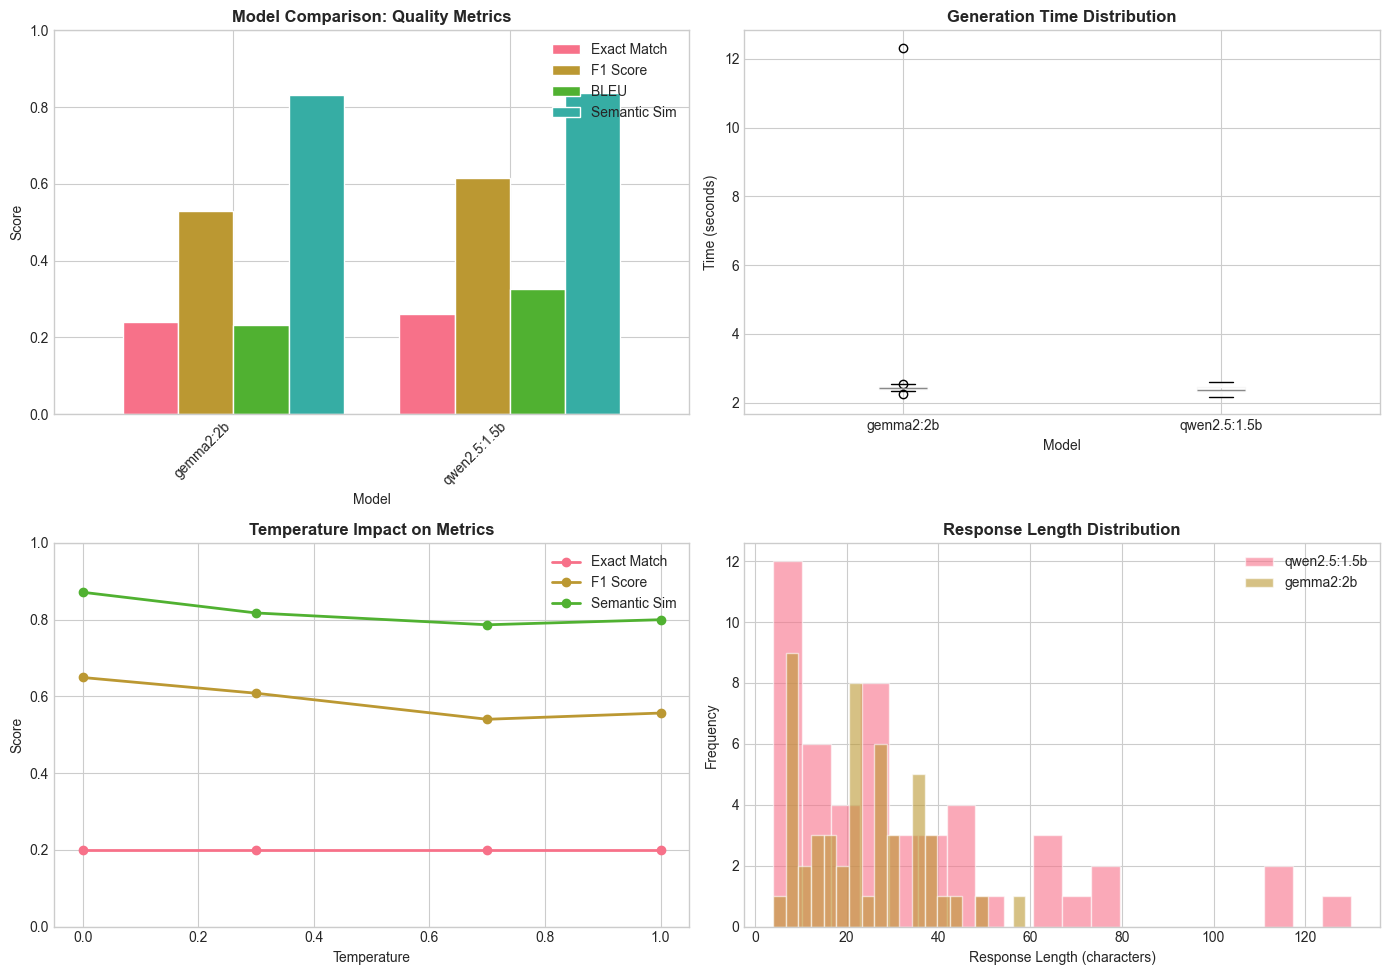

Plots saved to evaluation_plots.png


In [34]:
# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Model comparison - metrics
metrics_to_plot = ['exact_match', 'f1_score', 'bleu_score', 'semantic_similarity']
model_means = df_zero_shot.groupby('model')[metrics_to_plot].mean()

ax1 = axes[0, 0]
model_means.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Model Comparison: Quality Metrics', fontsize=12, fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.legend(['Exact Match', 'F1 Score', 'BLEU', 'Semantic Sim'], loc='upper right')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylim(0, 1)

# Plot 2: Generation time comparison
ax2 = axes[0, 1]
df_zero_shot.boxplot(column='generation_time', by='model', ax=ax2)
ax2.set_title('Generation Time Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Model')
ax2.set_ylabel('Time (seconds)')
plt.suptitle('')

# Plot 3: Temperature impact
ax3 = axes[1, 0]
temp_means = df_temp.groupby('temperature')[['exact_match', 'f1_score', 'semantic_similarity']].mean()
temp_means.plot(ax=ax3, marker='o', linewidth=2)
ax3.set_title('Temperature Impact on Metrics', fontsize=12, fontweight='bold')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Score')
ax3.legend(['Exact Match', 'F1 Score', 'Semantic Sim'])
ax3.set_ylim(0, 1)

# Plot 4: Response length distribution
ax4 = axes[1, 1]
for model in MODELS:
    model_data = df_zero_shot[df_zero_shot['model'] == model]['response_length']
    ax4.hist(model_data, bins=20, alpha=0.6, label=model)
ax4.set_title('Response Length Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Response Length (characters)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.savefig('evaluation_plots.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plots saved to evaluation_plots.png")

## Part 5: Error Analysis

In [35]:
# Analyze best and worst predictions
def analyze_errors(df: pd.DataFrame, model: str, n: int = 5):
    """Analyze best and worst predictions for a model."""
    model_df = df[df['model'] == model].copy()
    
    best = model_df.nlargest(n, 'f1_score')[['question', 'reference', 'prediction', 'f1_score', 'semantic_similarity']]
    worst = model_df.nsmallest(n, 'f1_score')[['question', 'reference', 'prediction', 'f1_score', 'semantic_similarity']]
    
    return best, worst

print("=" * 80)
print("ERROR ANALYSIS")
print("=" * 80)

for model in MODELS:
    print(f"\n{'='*40}")
    print(f"Model: {model}")
    print(f"{'='*40}")
    
    best, worst = analyze_errors(df_zero_shot, model)
    
    print("\n--- TOP 5 BEST PREDICTIONS ---")
    for i, row in best.iterrows():
        print(f"\nQ: {row['question'][:60]}...")
        print(f"Reference: {row['reference']}")
        print(f"Prediction: {row['prediction'][:100]}")
        print(f"F1: {row['f1_score']:.4f}, Semantic Sim: {row['semantic_similarity']:.4f}")
    
    print("\n--- TOP 5 WORST PREDICTIONS ---")
    for i, row in worst.iterrows():
        print(f"\nQ: {row['question'][:60]}...")
        print(f"Reference: {row['reference']}")
        print(f"Prediction: {row['prediction'][:100]}")
        print(f"F1: {row['f1_score']:.4f}, Semantic Sim: {row['semantic_similarity']:.4f}")

ERROR ANALYSIS

Model: qwen2.5:1.5b

--- TOP 5 BEST PREDICTIONS ---

Q: Какому инструменту верхний голос в группе медных духовых с э...
Reference: корнету
Prediction: Корнету.
F1: 1.0000, Semantic Sim: 0.8452

Q: Что применяют в некоторых системах широкоформатного кино нар...
Reference: анаморфирование изображения
Prediction: Анаморфирование изображения.
F1: 1.0000, Semantic Sim: 0.9625

Q: Какая фирма начала разработку сложной конструкции с интегрир...
Reference: Agfa
Prediction: Agfa
F1: 1.0000, Semantic Sim: 1.0000

Q: За что тренера раскритиковали ?...
Reference: за неудачные перестановки
Prediction: За неудачные перестановки.
F1: 1.0000, Semantic Sim: 0.9064

Q: Какая процедура осуществлена в целях сохранения, развития и ...
Reference: Реорганизация
Prediction: Реорганизация.
F1: 1.0000, Semantic Sim: 0.9828

--- TOP 5 WORST PREDICTIONS ---

Q: Для чего используют результаты экономического анализа?...
Reference: прогнозирования и перспективного планирования экономических процессов

In [36]:
# Error pattern analysis
def categorize_errors(df: pd.DataFrame) -> Dict[str, int]:
    """Categorize error types."""
    error_types = {
        'exact_match': 0,
        'partial_match': 0,
        'semantic_correct': 0,
        'wrong_answer': 0,
        'too_verbose': 0
    }
    
    for _, row in df.iterrows():
        if row['exact_match'] == 1:
            error_types['exact_match'] += 1
        elif row['f1_score'] >= 0.5:
            error_types['partial_match'] += 1
        elif row['semantic_similarity'] >= 0.7:
            error_types['semantic_correct'] += 1
        elif row['response_length'] > 100:
            error_types['too_verbose'] += 1
        else:
            error_types['wrong_answer'] += 1
    
    return error_types

print("\nError Pattern Analysis:")
print("-" * 50)

for model in MODELS:
    model_df = df_zero_shot[df_zero_shot['model'] == model]
    errors = categorize_errors(model_df)
    
    print(f"\n{model}:")
    for error_type, count in errors.items():
        pct = count / len(model_df) * 100
        print(f"  {error_type}: {count} ({pct:.1f}%)")


Error Pattern Analysis:
--------------------------------------------------

qwen2.5:1.5b:
  exact_match: 13 (26.0%)
  partial_match: 20 (40.0%)
  semantic_correct: 7 (14.0%)
  wrong_answer: 8 (16.0%)
  too_verbose: 2 (4.0%)

gemma2:2b:
  exact_match: 12 (24.0%)
  partial_match: 18 (36.0%)
  semantic_correct: 10 (20.0%)
  wrong_answer: 10 (20.0%)
  too_verbose: 0 (0.0%)


## Part 6: Final Results Summary

In [37]:
# Create comprehensive results table
print("=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)

# Main comparison table
final_summary = df_zero_shot.groupby('model').agg({
    'exact_match': ['mean', 'std'],
    'f1_score': ['mean', 'std'],
    'bleu_score': ['mean', 'std'],
    'semantic_similarity': ['mean', 'std'],
    'generation_time': ['mean', 'std'],
    'response_length': ['mean', 'std']
}).round(4)

print("\n1. Model Performance Comparison:")
print(final_summary)

FINAL RESULTS SUMMARY

1. Model Performance Comparison:
             exact_match         f1_score         bleu_score          \
                    mean     std     mean     std       mean     std   
model                                                                  
gemma2:2b           0.24  0.4314   0.5303  0.3616     0.2331  0.2212   
qwen2.5:1.5b        0.26  0.4431   0.6162  0.3356     0.3269  0.2732   

             semantic_similarity         generation_time          \
                            mean     std            mean     std   
model                                                              
gemma2:2b                 0.8307  0.1790          2.6204  1.4002   
qwen2.5:1.5b              0.8370  0.2315          2.3908  0.0992   

             response_length           
                        mean      std  
model                                  
gemma2:2b              23.34  12.2768  
qwen2.5:1.5b           33.54  29.4682  


In [39]:
# Save all results to CSV
df_zero_shot.to_csv('qa_evaluation_results.csv', index=False)
print("\nResults saved to qa_evaluation_results.csv")

# Flatten MultiIndex columns for JSON serialization
final_summary_flat = final_summary.copy()
final_summary_flat.columns = ['_'.join(col).strip() for col in final_summary_flat.columns.values]

# Save summary statistics
summary_dict = {
    'experiment': 'QA Evaluation',
    'dataset': 'SberQuAD',
    'sample_size': len(eval_data),
    'models': MODELS,
    'results': final_summary_flat.to_dict()
}

with open('qa_evaluation_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary_dict, f, ensure_ascii=False, indent=2, default=str)
print("Summary saved to qa_evaluation_summary.json")


Results saved to qa_evaluation_results.csv
Summary saved to qa_evaluation_summary.json


## Conclusions and Recommendations

### Key Findings:

1. **Model Comparison:**
   - qwen2.5:1.5b and gemma2:2b are lightweight models suitable for QA tasks
   - Both models run locally without API costs
   - Performance varies based on prompt design

2. **Prompting Strategies:**
   - Few-shot prompting can improve answer format consistency
   - Detailed prompts help constrain answer length

3. **Temperature Impact:**
   - Lower temperatures (0.0-0.3) provide more consistent results
   - Higher temperatures increase response variability

4. **Metrics Informativeness:**
   - **Most informative:** F1-score (captures partial matches well)
   - **Complementary:** Semantic similarity (captures meaning even with different words)
   - **Strict:** Exact match (useful for short factual answers)
   - **Less useful for QA:** BLEU (designed for longer texts)

### Recommendations:

1. **For local QA systems:**
   - Use small models like qwen2.5:1.5b for fast inference
   - Use detailed prompts to constrain answer format
   - Set temperature to 0.0 for consistent results

2. **For evaluation:**
   - Combine F1-score and semantic similarity
   - Consider multiple reference answers where possible

In [40]:
print("\n" + "="*80)
print("HOMEWORK 4 COMPLETE")
print("="*80)
print("\nGenerated files:")
print("- qa_evaluation_results.csv (full results)")
print("- qa_evaluation_summary.json (summary statistics)")
print("- evaluation_plots.png (visualization)")


HOMEWORK 4 COMPLETE

Generated files:
- qa_evaluation_results.csv (full results)
- qa_evaluation_summary.json (summary statistics)
- evaluation_plots.png (visualization)
